In [13]:
import torch
import time
from sklearn.preprocessing import StandardScaler
samples = 100000

data_name = "val"
R=0

i = torch.randn((samples,2))*10
psi = torch.column_stack([i[:,0]**2+i[:,1],i[:,0]-i[:,1]**2])

ones = torch.ones((samples,))
L = torch.column_stack((2*i[:,0],ones,ones,-2*i[:,1]))


data = {"i":i,"psi":psi}
test_data = {"i":i[::100,:],"psi":psi[::100,:],"l":L[::100,:]}

In [11]:
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
import mlflow

class FluxModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2,40),
            nn.Tanh(),
            nn.Linear(40,40),
            nn.Tanh(),
            nn.Linear(40,2),
        )
        self.r = nn.Parameter(torch.tensor([0], dtype=float,requires_grad=True))
        
    def forward(self,x):
        return self.model(x),self.r

def log_visualization(data, pred, titles, color_label, plot_filename, value_range_indices, display=False):
    fig, ax = plt.subplots( 2, len(titles)//2, figsize=(8 * len(titles)//4, 6))
    ax = ax.reshape((len(titles),))
    combined_data = torch.column_stack((data, pred))
    
    # Determine value range
    pred_max = torch.max(pred, axis=0)[0]
    data_max = torch.max(data, axis=0)[0]
    max_values = torch.maximum(pred_max, data_max)
    
    pred_min = torch.min(pred, axis=0)[0]
    data_min = torch.min(data, axis=0)[0]
    min_values = torch.minimum(pred_min, data_min)
    
    # Create scatter plots
    for i in range(len(titles)):
        sc = ax[i].scatter(test_data["i"][:, 0], test_data["i"][:, 1], marker=".", c=combined_data[:, i], cmap='viridis',
                           vmin=min_values[value_range_indices[i]], vmax=max_values[value_range_indices[i]])
        
        # Add a color bar
        cbar = plt.colorbar(sc, ax=ax[i])
        cbar.set_label(color_label)
        
        # Set equal scaling for x and y axes and adjust the plot box
        ax[i].set_aspect('equal', 'box')
        
        # Add labels and title
        ax[i].set_xlabel('id [A]')
        ax[i].set_ylabel('iq [A]')
        ax[i].set_title(titles[i])
    
    # Adjust layout to fit everything nicely
    plt.tight_layout()
    plt.savefig(plot_filename)
    if not display:
        plt.close(fig)
    mlflow.log_artifact(plot_filename)

# Example usage for log_psi_error_plane
def log_psi_error_plane(pred, display=False):
    error = torch.abs(test_data["psi"] - pred)
    log_visualization(
        data=error,
        pred=error,
        titles=["Psid", "Psiq"],
        color_label='MAE [Wb]',
        plot_filename="Psi_mae.png",
        value_range_indices=[0, 1],
        display=display
    )

# Example usage for log_l_visualization
def log_l_visualization(pred, display=False):
    log_visualization(
        data=test_data["l"],
        pred=pred,
        titles=[
            "ldq from table", "ldq from table", "lqd from table", "lqq from table",
            "ldd estimated", "ldq estimated", "lqd estimated", "lqq estimated"
        ],
        color_label='l [Wb/A]',
        plot_filename="L.png",
        value_range_indices=[0, 1, 2, 3, 0, 1, 2, 3],
        display=display
    )

# Example usage for log_prediction_visualization
def log_prediction_visualization(pred, display=False):
    log_visualization(
        data=test_data["psi"],
        pred=pred,
        titles=["Psid from flux table", "Psiq from flux table", "Psid estimated", "Psiq estimated"],
        color_label='Psi [Wb]',
        plot_filename="Psi.png",
        value_range_indices=[0, 1, 0, 1],
        display=display
    )
def compute_differential_inductances(model):
    model.eval()
    jacobi = torch.autograd.functional.jacobian(model.model,test_data["i"])
    inductances = torch.diagonal(jacobi,dim1=0,dim2=2)
    inductances = inductances.reshape((4,inductances.shape[2])).transpose(0,1)
    return inductances

def calc_derivative(outputs,inputs):
    partial_derivatives = []
    for i in range(outputs.shape[1]):
        grad_outputs = torch.zeros_like(outputs)
        grad_outputs[:, i] = 1
        grads = torch.autograd.grad(outputs, inputs, grad_outputs=grad_outputs, create_graph=True)[0]
        partial_derivatives.append(grads)
    return partial_derivatives


In [8]:
model=FluxModel()
loss_fn = torch.nn.L1Loss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

epochs = 500
batchsize = 1024
for e in range(epochs):
    for i in range(0,samples,batchsize):
        model.train()
        pred,r = model(data["i"][i:i+batchsize,:])
        loss = loss_fn(pred,data["psi"][i:i+batchsize,:])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f" epoch {e} : loss {loss}")

 epoch 0 : loss 96.03939056396484
 epoch 1 : loss 91.42364501953125
 epoch 2 : loss 88.682861328125
 epoch 3 : loss 86.94952392578125
 epoch 4 : loss 85.58898162841797
 epoch 5 : loss 83.99713134765625
 epoch 6 : loss 81.522705078125
 epoch 7 : loss 79.73219299316406
 epoch 8 : loss 77.84191131591797
 epoch 9 : loss 75.99618530273438
 epoch 10 : loss 74.37049865722656
 epoch 11 : loss 72.76785278320312
 epoch 12 : loss 71.3128662109375
 epoch 13 : loss 69.94169616699219
 epoch 14 : loss 68.62752532958984
 epoch 15 : loss 67.36383819580078
 epoch 16 : loss 65.96866607666016
 epoch 17 : loss 64.65617370605469
 epoch 18 : loss 63.4073600769043
 epoch 19 : loss 62.17403030395508
 epoch 20 : loss 61.00259780883789
 epoch 21 : loss 59.8729248046875
 epoch 22 : loss 58.79471969604492
 epoch 23 : loss 57.75560760498047
 epoch 24 : loss 56.74641799926758
 epoch 25 : loss 55.77018737792969
 epoch 26 : loss 54.831199645996094
 epoch 27 : loss 53.85578918457031
 epoch 28 : loss 52.92765808105469
 

0.0010004043579101562


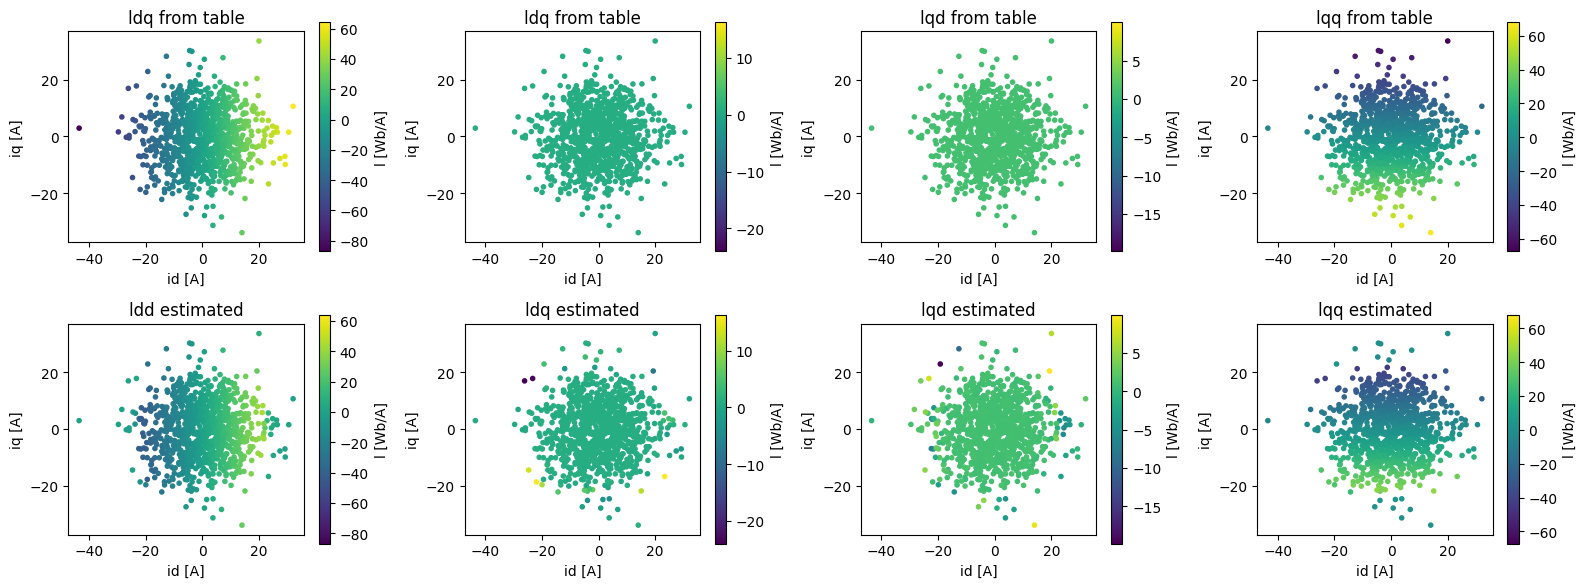

In [17]:
inputs = test_data["i"].clone().detach().requires_grad_(True)
pred,r = model(inputs)
start = time.time()
deriv = calc_derivative(pred,inputs)
deriv = torch.column_stack(deriv)
deriv = deriv.detach()
print(time.time()-start)
log_l_visualization(deriv,display=True)

0.4973766803741455


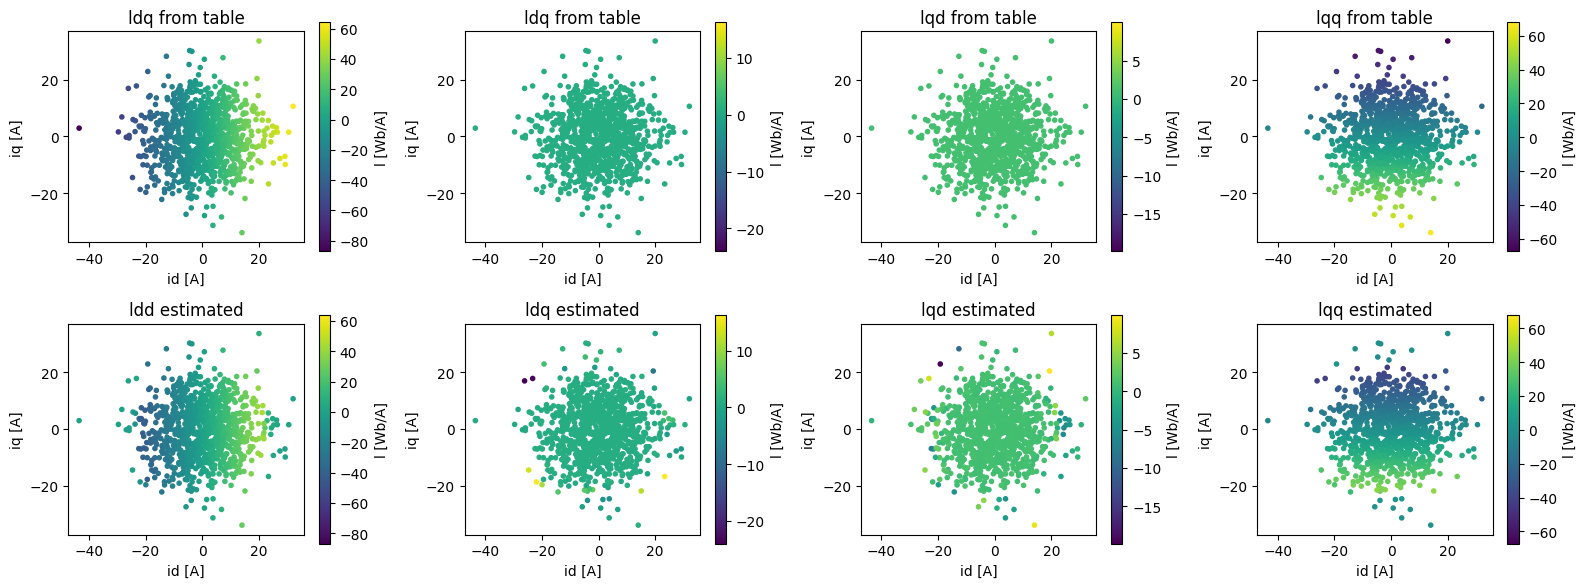

In [15]:
model.eval()
with torch.no_grad():
    pred,r = model(test_data["i"])
    #log_psi_error_plane(pred,display=True)
    #log_prediction_visualization(pred,display=True)
    start = time.time()
    deriv = compute_differential_inductances(model)
    print(time.time()-start)
    log_l_visualization(deriv,display=True)